# **Process OD table from Synergy plate reader and make growth curves**

### **Extract tables from Excel files:** 
- From the *file with the incubation measures*, copy and paste the table below *"O.D. corrigida para 1 cm"* to another excel file. Then, save this new file as od600_tp.csv
- From the file with the *time point 0* measure, copy and paste the table next to *"O.D. corrigida para 1 cm"* to another excel file. Then, save this new file as od600_tp.csv
- *Additional time points beyond those in incubation*: od600_tpX, with X being the corresponding time point measured.

In [32]:
# Load packages
library(dplyr)
library(tidyr)
library(hms)
library(lubridate)
library(ggplot2)
library(purrr)
library(patchwork)
library(tidyverse)
library(ggpubr)

In [4]:
setwd("/home/strawberry/Documents/Masters/coculture/Vitor") # change the location to where your csv files are

In [5]:
# Read raw file (semicolon/comma decimal issue to handle)
raw <- read.csv("od600_tp0.csv", header = FALSE, skip = 1, na.strings = c("", "NA"))

# Set row names A-H and remove first column (empty)
rownames(raw) <- LETTERS[1:8]
raw <- raw[, -1]

# Replace commas with dots and convert to numeric (preserving matrix shape)
raw_numeric <- raw %>%
  mutate(across(everything(), ~ as.numeric(gsub(",", ".", .))))

# Generate well names in row-major order: A1–A12, B1–B12, ..., H1–H12
rows <- LETTERS[1:8]
cols <- 1:12
well_names <- unlist(lapply(rows, function(r) paste0(r, cols)))

# Flatten by row (to match well naming order)
values <- as.vector(t(as.matrix(raw_numeric)))
names(values) <- well_names

# Create final formatted data frame
formatted_df <- as.data.frame(t(values))
formatted_df <- formatted_df %>% mutate(Time = "00:00:00") %>% select(Time, everything())

print(formatted_df)

      Time A1 A2 A3 A4 A5 A6 A7 A8 A9 A10 A11 A12 B1    B2    B3    B4    B5
1 00:00:00 NA NA NA NA NA NA NA NA NA  NA  NA  NA NA 0.062 0.032 0.022 0.027
     B6    B7    B8    B9   B10   B11 B12 C1    C2    C3    C4    C5   C6    C7
1 0.024 0.023 0.026 0.027 0.027 0.023  NA NA 0.043 0.029 0.035 0.027 0.03 0.027
     C8    C9   C10   C11 C12 D1    D2   D3    D4    D5    D6    D7   D8    D9
1 0.034 0.035 0.055 0.029  NA NA 0.058 0.03 0.025 0.029 0.032 0.028 0.03 0.035
    D10   D11 D12 E1    E2    E3    E4    E5    E6   E7    E8    E9  E10   E11
1 0.036 0.041  NA NA 0.024 0.021 0.026 0.024 0.032 0.03 0.027 0.029 0.03 0.004
  E12 F1    F2   F3    F4    F5    F6   F7    F8    F9   F10    F11 F12 G1
1  NA NA 0.034 0.02 0.025 0.029 0.026 0.04 0.029 0.029 0.035 -0.001  NA NA
     G2    G3   G4    G5    G6    G7   G8    G9   G10    G11 G12 H1 H2 H3 H4 H5
1 0.032 0.021 0.02 0.026 0.026 0.028 0.04 0.062 0.035 -0.004  NA NA NA NA NA NA
  H6 H7 H8 H9 H10 H11 H12
1 NA NA NA NA  NA  NA  NA


In [6]:
# Load and clean `od600_tp.csv` (replace "," decimal and quotes)
od_tp <- read_csv("od600_tp.csv", na = c("", "NA")) %>%
  mutate(across(
    -Time,
    ~ .x %>%
      str_remove_all('"') %>%         # remove any surrounding quotes
      str_replace_all(",", ".") %>%   # convert decimal commas to dots
      as.numeric()
  ))

head(od_tp)

Rows: 145 Columns: 61
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (59): B2, B3, B4, B5, B6, B7, B8, B9, B10, B11, C2, C3, C4, C5, C6, C7,...
num   (1): F11
time  (1): Time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Time,B2,B3,B4,B5,B6,B7,B8,B9,B10,⋯,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11
<time>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
00:29:35,0.130,0.059,0.044,0.054,0.048,0.053,0.084,0.055,0.060,⋯,0.078,0.049,0.053,0.048,0.048,0.065,0.079,0.137,0.067,-0.005
00:59:35,0.167,0.065,0.052,0.057,0.052,0.074,0.089,0.085,0.066,⋯,0.098,0.055,0.071,0.053,0.061,0.098,0.090,0.186,0.089,-0.003
01:29:35,0.220,0.086,0.079,0.069,0.064,0.156,0.109,0.142,0.111,⋯,0.135,0.070,0.097,0.068,0.085,0.163,0.136,0.274,0.127,-0.004
01:59:35,0.335,0.110,0.125,0.110,0.092,0.235,0.154,0.193,0.182,⋯,0.196,0.094,0.156,0.117,0.116,0.268,0.192,0.427,0.177,-0.005
02:29:35,0.475,0.147,0.221,0.149,0.118,0.358,0.218,0.302,0.256,⋯,0.296,0.131,0.217,0.157,0.152,0.396,0.261,0.560,0.234,-0.005
02:59:35,0.643,0.211,0.270,0.215,0.173,0.406,0.238,0.669,0.325,⋯,0.350,0.179,0.253,0.224,0.212,0.483,0.322,0.577,0.290,-0.004


In [8]:
common_cols <- intersect(colnames(formatted_df), colnames(od_tp))
common_cols # this should print out all columns names 

[1] "Time" "B2"   "B3"   "B4"   "B5"   "B6"   "B7"   "B8"   "B9"   "B10" 
[11] "B11"  "C2"   "C3"   "C4"   "C5"   "C6"   "C7"   "C8"   "C9"   "C10" 
[21] "C11"  "D2"   "D3"   "D4"   "D5"   "D6"   "D7"   "D8"   "D9"   "D10" 
[31] "D11"  "E2"   "E3"   "E4"   "E5"   "E6"   "E7"   "E8"   "E9"   "E10" 
[41] "E11"  "F2"   "F3"   "F4"   "F5"   "F6"   "F7"   "F8"   "F9"   "F10" 
[51] "F11"  "G2"   "G3"   "G4"   "G5"   "G6"   "G7"   "G8"   "G9"   "G10" 
[61] "G11"

In [9]:
# Reorder columns match between tables and convert both time columns to character
formatted_df_clean <- formatted_df %>%
  select(all_of(common_cols)) %>%
  mutate(Time = as.character(Time))

od_tp_clean <- od_tp %>%
  select(all_of(common_cols)) %>%
  mutate(Time = as.character(Time))

head(formatted_df_clean)
head(od_tp_clean)

,Time,B2,B3,B4,B5,B6,B7,B8,B9,B10,⋯,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,00:00:00,0.062,0.032,0.022,0.027,0.024,0.023,0.026,0.027,0.027,⋯,0.032,0.021,0.02,0.026,0.026,0.028,0.04,0.062,0.035,-0.004


Time,B2,B3,B4,B5,B6,B7,B8,B9,B10,⋯,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
00:29:35,0.130,0.059,0.044,0.054,0.048,0.053,0.084,0.055,0.060,⋯,0.078,0.049,0.053,0.048,0.048,0.065,0.079,0.137,0.067,-0.005
00:59:35,0.167,0.065,0.052,0.057,0.052,0.074,0.089,0.085,0.066,⋯,0.098,0.055,0.071,0.053,0.061,0.098,0.090,0.186,0.089,-0.003
01:29:35,0.220,0.086,0.079,0.069,0.064,0.156,0.109,0.142,0.111,⋯,0.135,0.070,0.097,0.068,0.085,0.163,0.136,0.274,0.127,-0.004
01:59:35,0.335,0.110,0.125,0.110,0.092,0.235,0.154,0.193,0.182,⋯,0.196,0.094,0.156,0.117,0.116,0.268,0.192,0.427,0.177,-0.005
02:29:35,0.475,0.147,0.221,0.149,0.118,0.358,0.218,0.302,0.256,⋯,0.296,0.131,0.217,0.157,0.152,0.396,0.261,0.560,0.234,-0.005
02:59:35,0.643,0.211,0.270,0.215,0.173,0.406,0.238,0.669,0.325,⋯,0.350,0.179,0.253,0.224,0.212,0.483,0.322,0.577,0.290,-0.004


In [11]:
# Combine data frames
od_combined <- bind_rows(formatted_df_clean, od_tp_clean)
print(head(od_combined))

      Time    B2    B3    B4    B5    B6    B7    B8    B9   B10   B11    C2
1 00:00:00 0.062 0.032 0.022 0.027 0.024 0.023 0.026 0.027 0.027 0.023 0.043
2 00:29:35 0.130 0.059 0.044 0.054 0.048 0.053 0.084 0.055 0.060 0.050 0.091
3 00:59:35 0.167 0.065 0.052 0.057 0.052 0.074 0.089 0.085 0.066 0.065 0.152
4 01:29:35 0.220 0.086 0.079 0.069 0.064 0.156 0.109 0.142 0.111 0.080 0.204
5 01:59:35 0.335 0.110 0.125 0.110 0.092 0.235 0.154 0.193 0.182 0.117 0.309
6 02:29:35 0.475 0.147 0.221 0.149 0.118 0.358 0.218 0.302 0.256 0.169 0.392
     C3    C4    C5    C6    C7    C8    C9   C10   C11    D2    D3    D4    D5
1 0.029 0.035 0.027 0.030 0.027 0.034 0.035 0.055 0.029 0.058 0.030 0.025 0.029
2 0.059 0.073 0.052 0.051 0.052 0.063 0.083 0.112 0.061 0.125 0.058 0.051 0.056
3 0.061 0.093 0.057 0.061 0.123 0.072 0.112 0.130 0.073 0.158 0.062 0.081 0.061
4 0.074 0.146 0.069 0.074 0.169 0.136 0.173 0.171 0.095 0.224 0.075 0.129 0.086
5 0.111 0.196 0.111 0.117 0.217 0.164 0.247 0.252 0.173 0.346

In [12]:
# Reshape to long format
od_long <- od_combined %>%
  pivot_longer(
    cols = -Time,
    names_to = "well",
    values_to = "OD600"
  )

# Define well groups
usa300_cols <- c("B2", "B3", "B4", "B5", "B6",
                 "C2", "C3", "C4", "C5", "C6",
                 "D2", "D3", "D4", "D5", "D6",
                 "E2", "E3", "E4", "E5", "E6",
                 "F2", "F3", "F4", "F5", "F6",
                 "G2", "G3", "G4", "G5", "G6")

newman_cols <- c("B7", "B8", "B9", "B10", "B11",
                 "C7", "C8", "C9", "C10", "C11",
                 "D7", "D8", "D9", "D10", "D11",
                 "E7", "E8", "E9", "E10", # skip E11 (blank)
                 "F7", "F8", "F9", "F10", # skip F11 (blank)
                 "G7", "G8", "G9", "G10") # skip G11 (blank)

blank_cols <- c("E11", "F11", "G11")

# Map wells to carbon sources
carbon_map <- list(
  CLM_GLU = c("B2", "C2", "D2", "E2", "F2", "G2",   # USA300
              "B7", "C7", "D7", "E7", "F7", "G7"),  # Newman
  CLM_SIA = c("B3", "C3", "D3", "E3", "F3", "G3",
              "B8", "C8", "D8", "E8", "F8", "G8"),
  CLM_MAN = c("B4", "C4", "D4", "E4", "F4", "G4",
              "B9", "C9", "D9", "E9", "F9", "G9"),
  CLM_LAC = c("B5", "C5", "D5", "E5", "F5", "G5",
              "B10", "C10", "D10", "E10", "F10", "G10"),
  CLM     = c("B6", "C6", "D6", "E6", "F6", "G6",
              "B11", "C11", "D11") # Newman CLM wells only up to D11
)

# Create metadata
od_long <- od_long %>%
  mutate(
    strain = case_when(
      well %in% usa300_cols ~ "USA300",
      well %in% newman_cols ~ "Newman",
      well %in% blank_cols ~ "Blank",
      TRUE ~ "Unknown"
    ),
    carbon_source = case_when(
      well %in% carbon_map$CLM_GLU ~ "CLM_GLU",
      well %in% carbon_map$CLM_SIA ~ "CLM_SIA",
      well %in% carbon_map$CLM_MAN ~ "CLM_MAN",
      well %in% carbon_map$CLM_LAC ~ "CLM_LAC",
      well %in% carbon_map$CLM ~ "CLM",
      well %in% blank_cols ~ "Blank",
      TRUE ~ "Unknown"
    )
  )

head(od_long)

Time,well,OD600,strain,carbon_source
<chr>,<chr>,<dbl>,<chr>,<chr>
00:00:00,B2,0.062,USA300,CLM_GLU
00:00:00,B3,0.032,USA300,CLM_SIA
00:00:00,B4,0.022,USA300,CLM_MAN
00:00:00,B5,0.027,USA300,CLM_LAC
00:00:00,B6,0.024,USA300,CLM
00:00:00,B7,0.023,Newman,CLM_GLU


In [13]:
# Create a duration column (in hours)
od_long <- od_long %>%
  separate(Time, into = c("H", "M", "S"), sep = ":", convert = TRUE) %>%
  mutate(
    Time_hr = H + M / 60 + S / 3600
  ) %>%
  select(-H, -M, -S)  # optional: drop split columns
print(head(od_long))

# A tibble: 6 × 5
  well  OD600 strain carbon_source Time_hr
  <chr> <dbl> <chr>  <chr>           <dbl>
1 B2    0.062 USA300 CLM_GLU             0
2 B3    0.032 USA300 CLM_SIA             0
3 B4    0.022 USA300 CLM_MAN             0
4 B5    0.027 USA300 CLM_LAC             0
5 B6    0.024 USA300 CLM                 0
6 B7    0.023 Newman CLM_GLU             0


In [14]:
# Remove "Unknown" before computing residuals
od_long <- od_long %>%
  filter(carbon_source != "Unknown")
head(od_long)

well,OD600,strain,carbon_source,Time_hr
<chr>,<dbl>,<chr>,<chr>,<dbl>
B2,0.062,USA300,CLM_GLU,0
B3,0.032,USA300,CLM_SIA,0
B4,0.022,USA300,CLM_MAN,0
B5,0.027,USA300,CLM_LAC,0
B6,0.024,USA300,CLM,0
B7,0.023,Newman,CLM_GLU,0


In [18]:
# Compute residuals (distance of each measure to the mean) and remove the biological replica more distant to the mean
## Calculate per group (strain, carbon_source, Time_hr) the mean OD600
group_means <- od_long %>%
  group_by(strain, carbon_source, Time_hr) %>%
  summarise(Mean_OD = mean(OD600, na.rm = TRUE), .groups = "drop")

head(group_means)

strain,carbon_source,Time_hr,Mean_OD
<chr>,<chr>,<dbl>,<dbl>
Blank,Blank,0.0000000,-0.0003333333
Blank,Blank,0.4930556,-0.3330000000
Blank,Blank,0.9930556,-0.9990000000
Blank,Blank,1.4930556,-0.9990000000
Blank,Blank,1.9930556,-0.9990000000
Blank,Blank,2.4930556,-0.9990000000


In [19]:
## Calculate, for each well, the overall "distance" from group means across all times
od_with_mean <- od_long %>%
  left_join(group_means, by = c("strain", "carbon_source", "Time_hr")) %>%
  mutate(residual = abs(OD600 - Mean_OD))

head(od_with_mean)

well,OD600,strain,carbon_source,Time_hr,Mean_OD,residual
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
B2,0.062,USA300,CLM_GLU,0,0.04216667,0.019833333
B3,0.032,USA300,CLM_SIA,0,0.02550000,0.006500000
B4,0.022,USA300,CLM_MAN,0,0.02550000,0.003500000
B5,0.027,USA300,CLM_LAC,0,0.02700000,0.000000000
B6,0.024,USA300,CLM,0,0.02833333,0.004333333
B7,0.023,Newman,CLM_GLU,0,0.02933333,0.006333333


In [22]:
## For each biological group (strain, condition, time), find the most deviant biological replicate
wells_to_remove <- od_with_mean %>%
  group_by(strain, carbon_source, Time_hr) %>%
  slice_max(residual, n = 1, with_ties = FALSE) %>%
  select(strain, carbon_source, Time_hr, well)

head(wells_to_remove)

strain,carbon_source,Time_hr,well
<chr>,<chr>,<dbl>,<chr>
Blank,Blank,0.0000000,E11
Blank,Blank,0.4930556,F11
Blank,Blank,0.9930556,F11
Blank,Blank,1.4930556,F11
Blank,Blank,1.9930556,F11
Blank,Blank,2.4930556,F11


In [23]:
## Remove those replicate entries from the original data
filtered_od <- od_long %>%
  anti_join(wells_to_remove, by = c("strain", "carbon_source", "Time_hr", "well")) 
head(filtered_od)

well,OD600,strain,carbon_source,Time_hr
<chr>,<dbl>,<chr>,<chr>,<dbl>
B4,0.022,USA300,CLM_MAN,0
B5,0.027,USA300,CLM_LAC,0
B7,0.023,Newman,CLM_GLU,0
B8,0.026,Newman,CLM_SIA,0
B9,0.027,Newman,CLM_MAN,0
B10,0.027,Newman,CLM_LAC,0


In [25]:
## Summarize mean and SD per group (without the worst replicate)
df_summary_filtered <- od_long %>%
  group_by(strain, carbon_source, Time_hr) %>%
  summarise(
    OD_mean = mean(OD600, na.rm = TRUE),
    OD_SD = sd(OD600, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  rename(Isolate = strain, Condition = carbon_source, Time = Time_hr)

print(df_summary_filtered)

# A tibble: 1,606 × 5
   Isolate Condition  Time   OD_mean   OD_SD
   <chr>   <chr>     <dbl>     <dbl>   <dbl>
 1 Blank   Blank     0     -0.000333 0.00404
 2 Blank   Blank     0.493 -0.333    0.578  
 3 Blank   Blank     0.993 -0.999    1.73   
 4 Blank   Blank     1.49  -0.999    1.73   
 5 Blank   Blank     1.99  -0.999    1.73   
 6 Blank   Blank     2.49  -0.999    1.73   
 7 Blank   Blank     2.99  -1.33     2.31   
 8 Blank   Blank     3.49  -1.33     2.31   
 9 Blank   Blank     3.99  -1.66     2.89   
10 Blank   Blank     4.49  -1.66     2.89   
# ℹ 1,596 more rows


In [27]:
unique(df_summary_filtered$Condition)

[1] "Blank"   "CLM"     "CLM_GLU" "CLM_LAC" "CLM_MAN" "CLM_SIA"

In [28]:
# Plot - trend 
plot_isolate <- function(isolate_id, data) {
  df_sub <- filter(data, Isolate == isolate_id)
  
  # Calculate max time rounded up to nearest even number for axis limits
  max_time <- ceiling(max(df_sub$Time) / 2) * 2
  
  ggplot(df_sub, aes(x = Time, y = OD_mean, color = Condition, fill = Condition)) + 
    geom_smooth(method = "loess", span = 0.4, se = TRUE, size = 1, alpha = 0.3) +  # Loess curve with confidence interval
    ylab("OD (600 nm)") + 
    xlab("Time (h)") + 
    ggtitle(paste(isolate_id)) + 
    scale_color_manual(values = condition_colors) + 
    scale_fill_manual(values = condition_colors) + 
    theme_classic() +
    theme(
      plot.title = element_text(size = 16, hjust = 0.5),
      axis.title = element_text(size = 14),
      axis.text = element_text(size = 12),
      legend.title = element_text(size = 12),
      legend.text = element_text(size = 10)
    ) +
    scale_y_continuous(limits = c(0, 3), breaks = seq(0, 3, by = 0.5)) + 
    scale_x_continuous(
      limits = c(0, max_time),
      breaks = seq(0, max_time, by = 6),
      expand = c(0, 0)
    )
}

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'


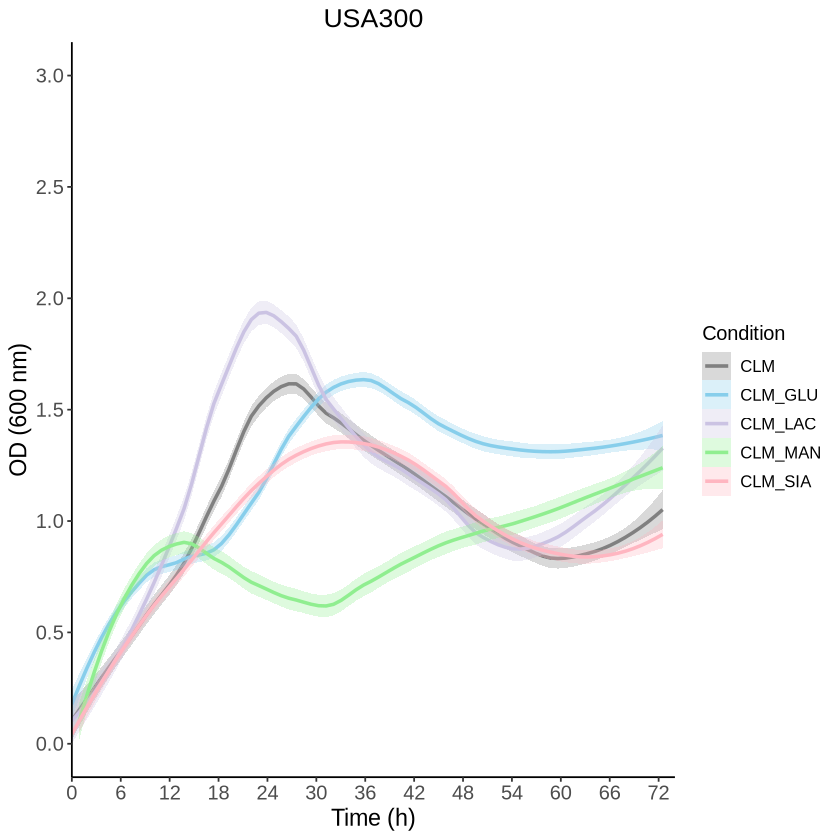

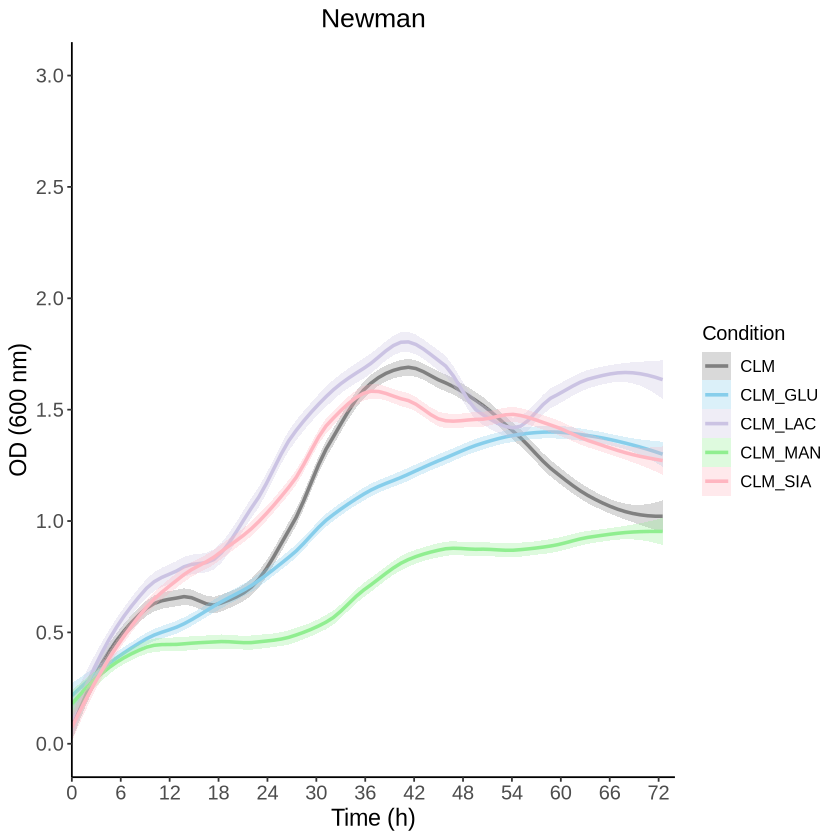

In [35]:
condition_colors <- c(
  "CLM" = "#808080",          # Gray
  "CLM_GLU" = "#87CEEB",      # Light Blue (SkyBlue)
  "CLM_LAC" = "#CBC3E3",  # Light purple
  "CLM_SIA" = "#FFB6C1",    # Light Pink
  "CLM_MAN" = "#90EE90"    # Light green
)

plot1 <- plot_isolate("USA300", df_summary_filtered)
plot2 <- plot_isolate("Newman", df_summary_filtered)
plot1
plot2

In [36]:
ggsave("USA300_120825.png", plot = plot1, width = 12, height = 6)
ggsave("Newman_120825.png", plot = plot2, width = 12, height = 6)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'


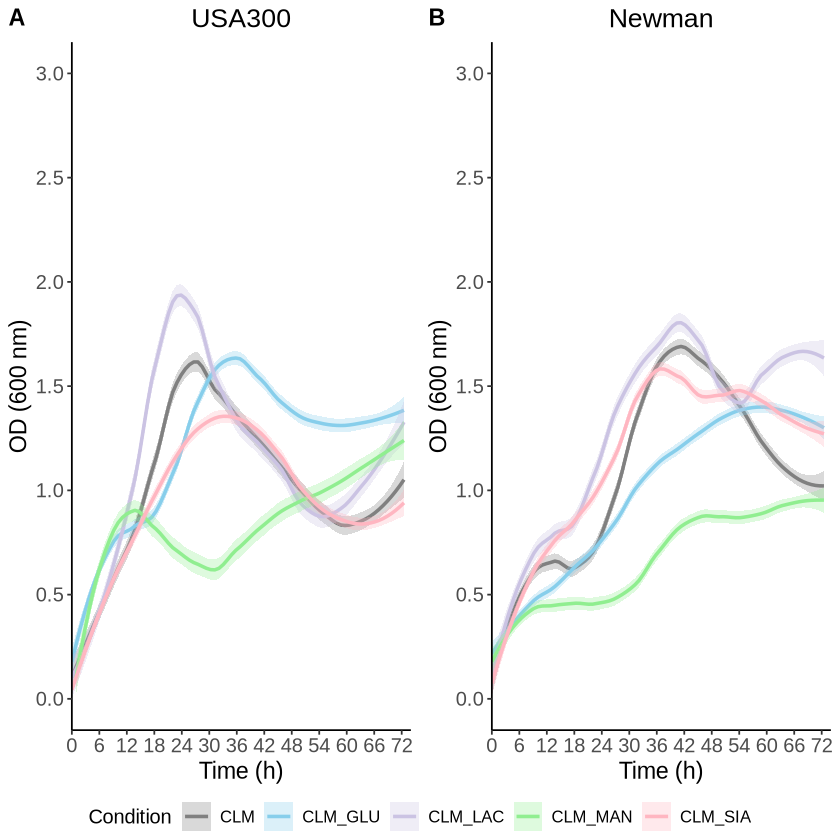

In [37]:
# Combine the two plots into a panel with labels
combined_plot <- ggarrange(
  plot1, plot2,
  labels = c("A", "B"),
  ncol = 2, nrow = 1,
  common.legend = TRUE,
  legend = "bottom"
)

# Show the panel
combined_plot
ggsave("Combined_plot_120825.png", plot = combined_plot, width = 12, height = 6)

In [38]:
# Plot - actual variation
plot_isolate <- function(isolate_id, data) {
  df_sub <- filter(data, Isolate == isolate_id)
  
  # Calculate max time rounded up to nearest even number for axis limits
  max_time <- ceiling(max(df_sub$Time) / 2) * 2
  
  ggplot(df_sub, aes(x = Time, y = OD_mean, color = Condition, fill = Condition)) + 
    # Real variation (SD ribbon)
    geom_ribbon(
      aes(ymin = OD_mean - OD_SD, ymax = OD_mean + OD_SD),
      alpha = 0.2, color = NA
    ) +
    # Smoothed trend line
    geom_smooth(method = "loess", span = 0.4, se = FALSE, size = 1) +
    ylab("OD (600 nm)") + 
    xlab("Time (h)") + 
    ggtitle(paste(isolate_id)) + 
    scale_color_manual(values = condition_colors) + 
    scale_fill_manual(values = condition_colors) + 
    theme_classic() +
    theme(
      plot.title = element_text(size = 16, hjust = 0.5),
      axis.title = element_text(size = 14),
      axis.text = element_text(size = 12),
      legend.title = element_text(size = 12),
      legend.text = element_text(size = 10)
    ) +
    scale_y_continuous(limits = c(0, 3), breaks = seq(0, 3, by = 0.5)) + 
    scale_x_continuous(
      limits = c(0, max_time),
      breaks = seq(0, max_time, by = 6),
      expand = c(0, 0)
    )
}

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'


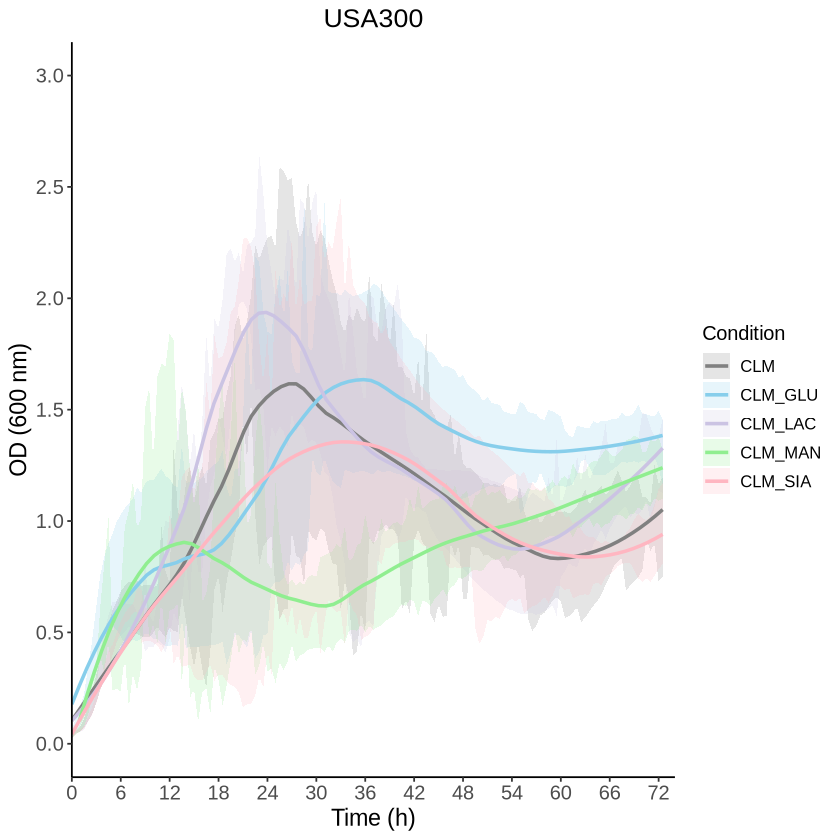

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'


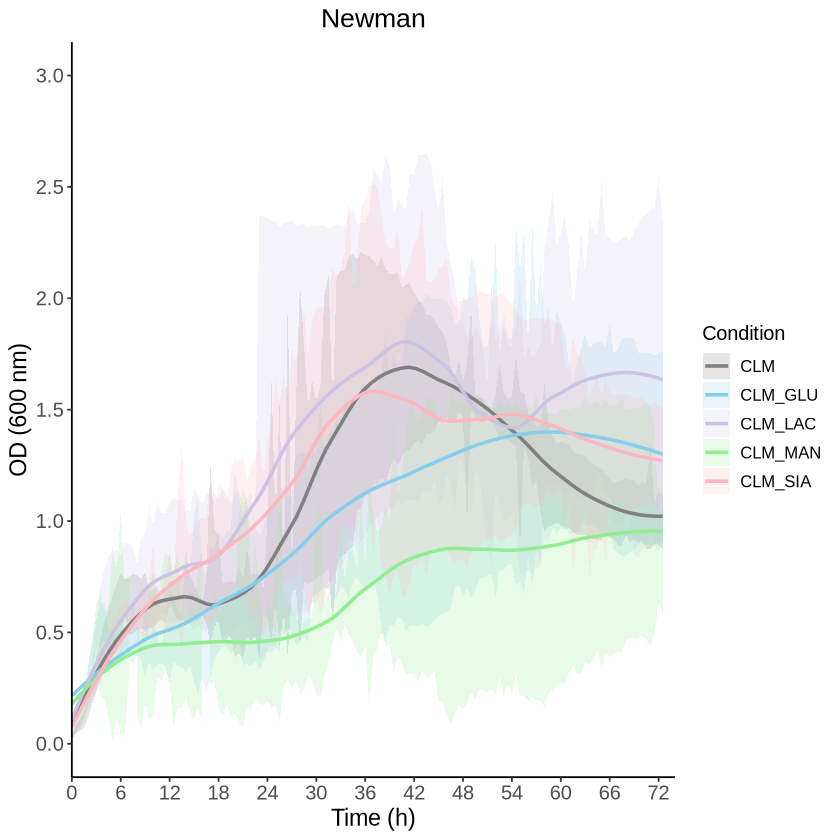

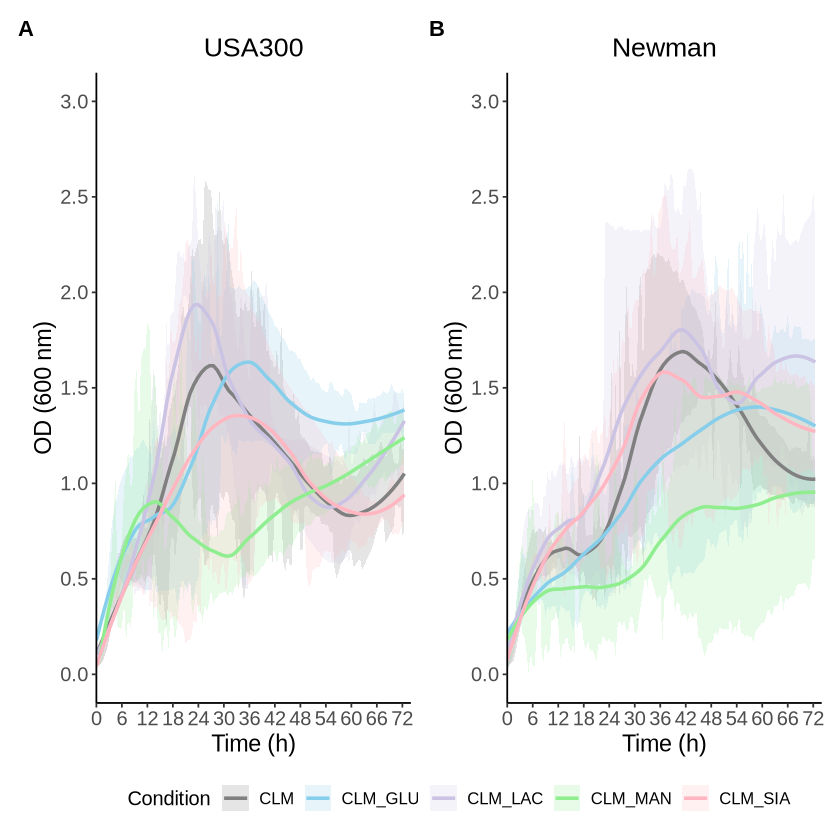

In [40]:
plot1 <- plot_isolate("USA300", df_summary_filtered)
plot2 <- plot_isolate("Newman", df_summary_filtered)
plot1
plot2

plot3 <- (plot1 + plot2 + 
            plot_layout(guides = "collect")) +  # collect shared legend
  plot_annotation(tag_levels = 'A') &          # A/B labels
  theme(
    legend.position = "bottom",
    plot.tag = element_text(face = "bold")     # make tags bold
  )

plot3